# Predicting Term Sheet Purchase

#### Model Buidling Steps

-  Load Dataset and Clean Data
-  Check for Outlers and Treat Outliers
-  Check for Class Imbalances 
-  Split Data into Train & Test Split
-  Build Preprocessing and Estimation Pipeline
- - Using Imblearn pipeline, OverSample minority class, apply PCA, and estimator (Logistic Regression (L1 regularization - lasso ) 
       & RandomForest Classifier)
- - Use GridSearch to serach for best parameters and estimators as well as PCA components

#### References

- https://stackoverflow.com/questions/46062679/right-order-of-doing-feature-selection-pca-and-normalization

- https://towardsdatascience.com/preventing-data-leakage-in-your-machine-learning-model-9ae54b3cd1fb

- https://www.mikulskibartosz.name/pca-how-to-choose-the-number-of-components/

- https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html

- https://stats.stackexchange.com/questions/363548/use-of-smote-with-training-test-and-dev-sets

- https://datascience.stackexchange.com/questions/27615/should-we-apply-normalization-to-test-data-as-well

- https://ro-che.info/articles/2017-12-11-pca-explained-variance

- https://www.researchgate.net/deref/http%3A%2F%2Fwww.marcoaltini.com%2Fblog%2Fdealing-with-imbalanced-data-undersampling-oversampling-and-proper-cross-validation

> Import analysis and visualization libraires

In [27]:
import pandas as pd
import numpy as np
%matplotlib inline 
import matplotlib.pyplot as plt
import seaborn as sns 
from pandas.api.types import is_numeric_dtype 

> import from project-defined modules

In [28]:
from plot import plot_univariate, plot_bivariate
from data import check_outliers, treat_outliers, scale_data, load_data
from model import check_imbalance, plot_pca_components, encode
from model import x_y_split, gridSearch, plot_grid_search, model_pipeline, metrics

> Import preprocessing libraries

In [29]:
from sklearn.preprocessing import StandardScaler,RobustScaler, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder, MultiLabelBinarizer
from imblearn.over_sampling import SMOTE, _random_over_sampler
from sklearn.decomposition import PCA
from sklearn.feature_selection import f_classif, from_model, SelectKBest,chi2, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest # outlier detection and re,oval
from collections import Counter

> Import estimator libraries

In [30]:
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.model_selection import KFold, StratifiedKFold, GridSearchCV
import xgboost
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.base import BaseEstimator, TransformerMixin

> Import libraries for measuring model perofrmance

In [31]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve
from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate

> Import production libraries

In [32]:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from imblearn.pipeline import Pipeline as ImbPipe
import joblib

> Import dataset

- drop duration column (directly impacts the target varible and not good for modelling)

In [33]:
path= '../../datasets/main_data/bank-additional-full.csv'
full_bank= load_data(path=path, sep=';', cols_to_drop=['duration'])
full_bank

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes


#### Data Preprocessing

In [34]:
full_bank.head(2)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [35]:
full_bank.dtypes

age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
contact            object
month              object
day_of_week        object
campaign            int64
pdays               int64
previous            int64
poutcome           object
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
y                  object
dtype: object

In [36]:
full_bank.isna().any()

age               False
job               False
marital           False
education         False
default           False
housing           False
loan              False
contact           False
month             False
day_of_week       False
campaign          False
pdays             False
previous          False
poutcome          False
emp.var.rate      False
cons.price.idx    False
cons.conf.idx     False
euribor3m         False
nr.employed       False
y                 False
dtype: bool

#### Outlier Detection and Treatment

> check for outliers

In [37]:
check_outliers(full_bank)

,age,campaign,pdays,previous,cons.conf.idx
0,56,1,999,0,-36.4
1,57,1,999,0,-36.4
2,37,1,999,0,-36.4
3,40,1,999,0,-36.4
4,56,1,999,0,-36.4
...,...,...,...,...,...
41183,73,1,999,0,-50.8
41184,46,1,999,0,-50.8
41185,56,2,999,0,-50.8
41186,44,1,999,0,-50.8


> treat outliers

In [38]:
clean_df1=treat_outliers(data=full_bank, type='isf')

In [39]:
clean_df1

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40579,35,services,married,university.degree,no,yes,no,telephone,sep,thu,1,999,0,nonexistent,-1.1,94.199,-37.5,0.884,4963.6,no
40659,46,services,married,university.degree,no,yes,no,cellular,sep,wed,1,999,0,nonexistent,-1.1,94.199,-37.5,0.880,4963.6,yes
40743,35,admin.,married,university.degree,no,yes,no,telephone,sep,wed,1,999,0,nonexistent,-1.1,94.199,-37.5,0.876,4963.6,no
40746,37,admin.,married,university.degree,no,no,yes,cellular,sep,thu,1,999,0,nonexistent,-1.1,94.199,-37.5,0.879,4963.6,yes


#### Now let's check for class imbalance

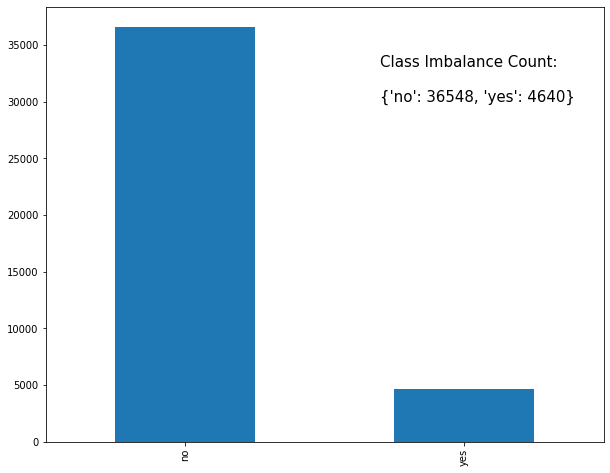

In [40]:
check_imbalance(full_bank, label='y')

> We have a very high class imbalance

> This would be dealt with after splitting out data to train and test and applied only to train to avoid data leakage

##### Let's encode our target variable

In [41]:
clean_df1.rename(columns={'y':'purchase'}, inplace=True)

/home/patrick/.local/lib/python3.6/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [42]:
clean_df1

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,purchase
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40579,35,services,married,university.degree,no,yes,no,telephone,sep,thu,1,999,0,nonexistent,-1.1,94.199,-37.5,0.884,4963.6,no
40659,46,services,married,university.degree,no,yes,no,cellular,sep,wed,1,999,0,nonexistent,-1.1,94.199,-37.5,0.880,4963.6,yes
40743,35,admin.,married,university.degree,no,yes,no,telephone,sep,wed,1,999,0,nonexistent,-1.1,94.199,-37.5,0.876,4963.6,no
40746,37,admin.,married,university.degree,no,no,yes,cellular,sep,thu,1,999,0,nonexistent,-1.1,94.199,-37.5,0.879,4963.6,yes


In [43]:
clean_df1['purchase'] = clean_df1['purchase'].map({'no':0, 'yes':1})

/home/patrick/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


#### split data

> Beofore further preprocessing, it is important we split the data into train and test set to avoid `data leakage`

In [44]:
features, target = clean_df1.drop('purchase', axis=1), pd.DataFrame(clean_df1['purchase'])

In [45]:
clean_df1

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,purchase
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
2,37,services,married,high.school,no,yes,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
4,56,services,married,high.school,no,no,yes,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40579,35,services,married,university.degree,no,yes,no,telephone,sep,thu,1,999,0,nonexistent,-1.1,94.199,-37.5,0.884,4963.6,0
40659,46,services,married,university.degree,no,yes,no,cellular,sep,wed,1,999,0,nonexistent,-1.1,94.199,-37.5,0.880,4963.6,1
40743,35,admin.,married,university.degree,no,yes,no,telephone,sep,wed,1,999,0,nonexistent,-1.1,94.199,-37.5,0.876,4963.6,0
40746,37,admin.,married,university.degree,no,no,yes,cellular,sep,thu,1,999,0,nonexistent,-1.1,94.199,-37.5,0.879,4963.6,1


#### encode categorical variables

In [46]:
features = encode(features)
features

,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,0,...,43,44,45,46,47,48,49,50,51,52
0,56,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,57,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,37,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,40,1,999,0,1.1,93.994,-36.4,4.857,5191.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,56,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37062,43,1,999,0,-2.9,92.469,-33.6,1.029,5076.2,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
37063,42,1,999,0,-2.9,92.469,-33.6,1.029,5076.2,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
37064,42,1,999,0,-2.9,92.469,-33.6,1.029,5076.2,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
37065,32,1,999,0,-2.9,92.469,-33.6,1.029,5076.2,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [49]:
target = target.iloc[0:features.shape[0]]

In [50]:
target

,purchase
0,0
1,0
2,0
3,0
4,0
...,...
37062,0
37063,0
37064,0
37065,0


In [51]:
X_train, X_test, y_train, y_test = train_test_split(features, target,
                                               test_size=.10, random_state=24)

In [52]:
X_train

,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,0,...,43,44,45,46,47,48,49,50,51,52
26554,49,1,999,0,-0.1,93.200,-42.0,4.076,5195.8,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3712,45,2,999,0,1.1,93.994,-36.4,4.859,5191.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
30678,43,1,999,2,-1.8,92.893,-46.2,1.344,5099.1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
31995,37,2,999,0,-1.8,92.893,-46.2,1.327,5099.1,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
8284,31,1,999,0,1.4,94.465,-41.8,4.864,5228.1,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6515,56,2,999,0,1.1,93.994,-36.4,4.857,5191.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
21780,58,1,999,0,1.4,93.444,-36.1,4.964,5228.1,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
20004,33,3,999,0,1.4,93.444,-36.1,4.966,5228.1,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
14639,34,5,999,0,1.4,93.918,-42.7,4.961,5228.1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [53]:
y_train

,purchase
26554,0
3712,0
30678,0
31995,0
8284,0
...,...
6515,0
21780,0
20004,0
14639,1


#### Deal with class imbalance

In [57]:
y_train['purchase'].value_counts() 

0    30472
1     2290
Name: purchase, dtype: int64

> Since we have an imbalance case of very high majority vs very low minority,

> a good decision would be to use the SMOTE technique of oversampling the minority to mathc the majority class

> However, accroding to some research, [example](https://kiwidamien.github.io/how-to-do-cross-validation-when-upsampling-data.html), oversmapling before cross validation is a bad idea, as it leads to  high scores but overfitted model. Hence we would suspend sampling till when we are ready to apply cross validation on the train sets

> We now have a balanced class and can go on to further preprocess

#### Normalize X_train and X_test datasets

> I would be using the RobustScaler which is less prone to outliers

In [58]:
X_train_scaled = scale_data(X_train) 
X_test_scaled = scale_data(X_test)

In [59]:
X_train_scaled

array([[ 0.78571429, -0.5       ,  0.        , ...,  1.        ,
        -1.        ,  0.        ],
       [ 0.5       ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.35714286, -0.5       ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.35714286,  0.5       ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.28571429,  1.5       ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.57142857,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [60]:
X_test_scaled

array([[ 0.21428571,  0.        ,  0.        , ...,  1.        ,
        -1.        ,  0.        ],
       [-0.5       ,  2.        ,  0.        , ...,  1.        ,
        -1.        ,  0.        ],
       [ 0.07142857,  1.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.71428571,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.5       , -0.5       ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.92857143,  3.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [61]:
X_train_scaled.shape 

(32762, 62)

#### Dimensionality Reduction

> RIght now, our input variables are quite large, which has potential of affecting our prediciton

> To optimise the predictive features of our variables and save memory space on the model,

> we can reduce the number of features using PCA

First let's plot the number of components we need to get the most explained variance of our data

- Xtrain

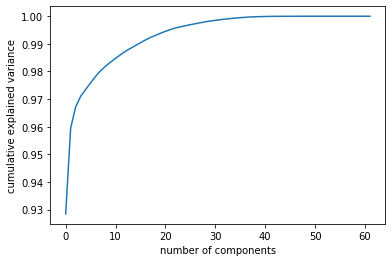

In [62]:
plot_pca_components(X_train_scaled)

From the plot above, we can see that we need about 50 components to get an high explained variance

and no longer 62 features from the scaled X train set

##### Before I move further let's test that PCA was a good decsion after all by fitting the PCA in a Logistic regression model usng stratified cross validation and comparing the score achived without using PCA

> All of this would be placed within a pipeline. 

> I would also be trying out other algrithms like XGboost and MultilayerPerceptron Netowrk (a neural network model for classification)

> Accroding to [this](https://imbalanced-learn.org/stable/generated/imblearn.pipeline.Pipeline.html) Imblearn pipeline example for working with SMOTE and PCA,

> I would be ordering my steps in the following order

1. SMOTE

2. PCA

3. ESTIMATOR

> Logistic Regression Modelling

In [63]:
X_test_scaled

array([[ 0.21428571,  0.        ,  0.        , ...,  1.        ,
        -1.        ,  0.        ],
       [-0.5       ,  2.        ,  0.        , ...,  1.        ,
        -1.        ,  0.        ],
       [ 0.07142857,  1.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.71428571,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.5       , -0.5       ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.92857143,  3.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [64]:
y_train = np.array(y_train).ravel()
y_train

array([0, 0, 0, ..., 0, 1, 0])

In [ ]:
class model_data()

In [65]:
log = LogisticRegression(max_iter=10000, tol=0.1)
log_model , predictions = model_pipeline(X_train_scaled,y_train,X_test_scaled, estimator=log)

metrics_obj = metrics(y_test, predictions)

In [37]:
metrics_obj.class_report()

              precision    recall  f1-score   support

         0.0       0.95      0.73      0.83      3386
         1.0       0.13      0.51      0.21       271

    accuracy                           0.72      3657
   macro avg       0.54      0.62      0.52      3657
weighted avg       0.89      0.72      0.78      3657



In [38]:
metrics_obj.conf_matrix()

,Actual_+ve,Actual_-ve
predicted_+ve,2484,902
predicted_-ve,134,137


In [39]:
metrics_obj.specif_sensitiv()

,sensitivity,specificity
0,0.505535,0.733609


In [40]:
metrics_obj.accuracy_score()

0.7167076838939022

In [41]:
LogisticRegression()

LogisticRegression()

In [42]:
scv = StratifiedKFold()
param_grid = {
    'pca__n_components': [5, 15, 30, 45, 64],
    'estimator__C': np.logspace(-4, 4, 4),
    'estimator__penalty': ['l1', 'l2']
}

In [43]:
type(log_model)

imblearn.pipeline.Pipeline

In [44]:
pca = PCA()

In [47]:
search = gridSearch(model=log_model, x_train=X_train_scaled, y_train=y_train, hyper_params=param_grid)

Best parameter (CV score=0.718):

{'estimator__C': 0.0001, 'estimator__penalty': 'l2', 'pca__n_components': 45}
<bound method BaseSearchCV.score of GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('imb_sample', SMOTE(random_state=123)),
                                       ('pca', PCA()),
                                       ('estimator',
                                        LogisticRegression(max_iter=10000,
                                                           tol=0.1))]),
             n_jobs=-1,
             param_grid={'estimator__C': array([1.00000000e-04, 4.64158883e-02, 2.15443469e+01, 1.00000000e+04]),
                         'estimator__penalty': ['l1', 'l2'],
                         'pca__n_components': [5, 15, 30, 45, 64]})>


Best parameter (CV score=0.718):

Best Params: {'estimator__C': 0.0001, 'estimator__penalty': 'l2', 'pca__n_components': 45}


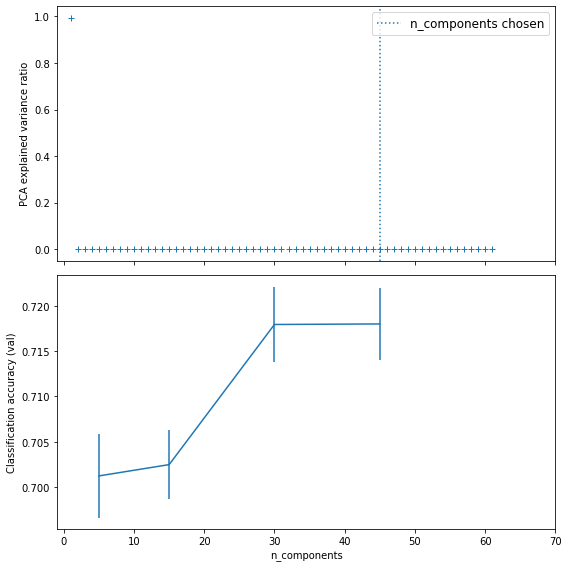

In [50]:
plot_grid_search(search, pca, X_train_scaled)

> 

> The plot above shows that from 30-50 PCA components to achieve high explained variance of our predictor varibles 

#### We can now rebuild our model with the  selected hyperparmateres from our GridSearch... 

<!-- But this time time around it would be placed in a pipeline -->

In [67]:
model1, model1_predictions = model_pipeline(X_train_scaled,y_train,X_test_scaled, pca=PCA(n_components=45), 
              estimator=LogisticRegression(penalty='l2',C=0.0001)) 

In [68]:
model1_predictions

array([1, 1, 0, ..., 0, 0, 0])

In [71]:
X_test_scaled

array([[ 0.21428571,  0.        ,  0.        , ...,  1.        ,
        -1.        ,  0.        ],
       [-0.5       ,  2.        ,  0.        , ...,  1.        ,
        -1.        ,  0.        ],
       [ 0.07142857,  1.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.71428571,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.5       , -0.5       ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.92857143,  3.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [73]:
type(X_test_scaled)

numpy.ndarray

In [74]:
model1.score(X_test_scaled, y_test)

0.7355122219170558

#### Our Logistic model performance is 73.55%